## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 35 columns):
DAMAGE_PROPERTY       8308 non-null float64
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 1 columns):
DAMAGE_PROPERTY    8308 non-null float64
dtypes: float64(1)
memory usage: 65.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 1:]


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 34 columns):
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP       8308 non-null float64
WOOD_WETLAND_PR

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
 0.5790
 0.1532
 0.2814
[torch.DoubleTensor of size 8308x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 0.0227 -1.6434 -0.4323  ...  -0.2947 -0.8098 -0.4531
-0.3046  0.2063  0.5545  ...  -0.2947  0.5157  1.1092
 0.3520 -0.3313 -0.8991  ...  -1.0297 -1.1142 -0.1038
          ...             ⋱             ...          
 0.5451 -0.2386  0.6373  ...  -1.0297  0.1597 -1.5301
 0.0227 -1.2487  0.6113  ...   0.8078  0.2605 -2.1918
 0.4583 -0.4701 -0.0348  ...  -1.7647 -0.3808  0.5064
[torch.DoubleTensor of size 8308x34]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 0.0227 -1.6434 -0.4323  ...  -0.2947 -0.8098 -0.4531
-0.3046  0.2063  0.5545  ...  -0.2947  0.5157  1.1092
 0.3520 -0.3313 -0.8991  ...  -1.0297 -1.1142 -0.1038
          ...             ⋱             ...          
 0.5451 -0.2386  0.6373  ...  -1.0297  0.1597 -1.5301
 0.0227 -1.2487  0.6113  ...   0.8078  0.2605 -2.1918
 0.4583 -0.4701 -0.0348  ...  -1.7647 -0.3808  0.5064
[torch.FloatTensor of size 8308x34]

## Two Hidden Layers with 100 Neurons each, Dropout = 5%

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.05),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.05),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 15000))

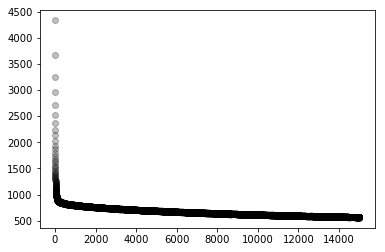

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8308)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

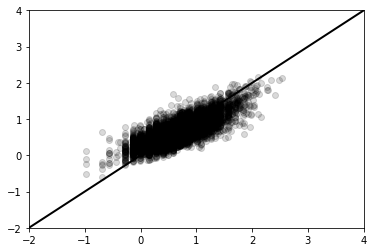

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)

In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 1:]


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)

In [19]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 266.6369
[torch.FloatTensor of size 1]

In [20]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4391
[torch.FloatTensor of size 1]

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2808)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.68884


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

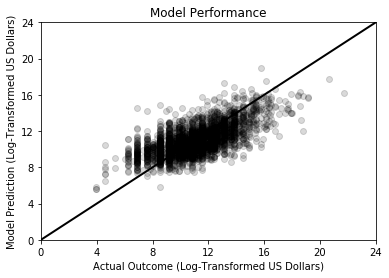

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 2.5%

In [24]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [25]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.025),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.025),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [26]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

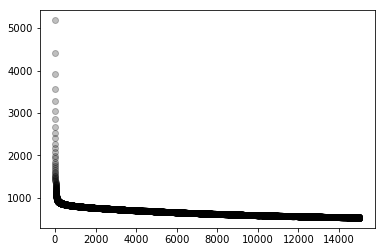

In [27]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [28]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

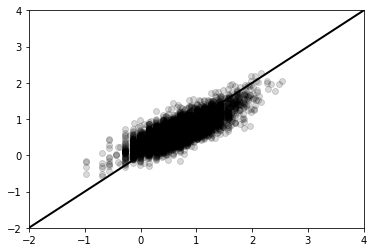

In [29]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [30]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 274.0966
[torch.FloatTensor of size 1]

In [31]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4234
[torch.FloatTensor of size 1]

In [32]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

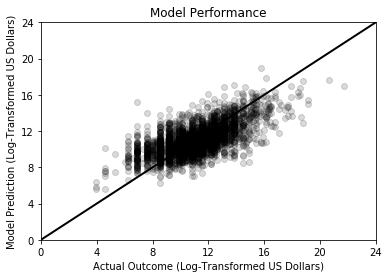

In [33]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 1%

In [34]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [35]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.01),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.01),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [36]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

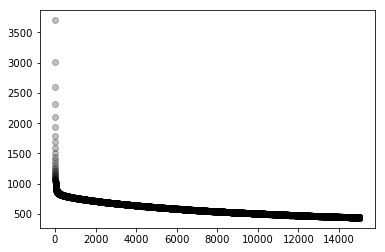

In [37]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [38]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

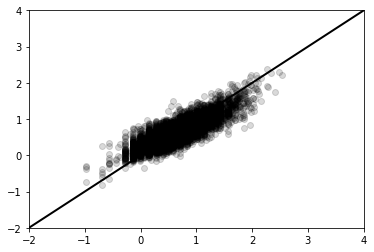

In [39]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [40]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 286.4280
[torch.FloatTensor of size 1]

In [41]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3975
[torch.FloatTensor of size 1]

In [42]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

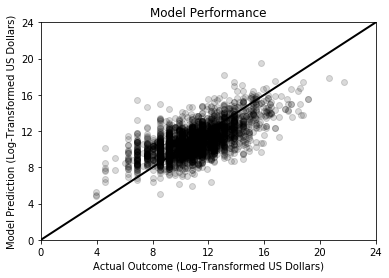

In [43]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 50%

In [44]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [45]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [46]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

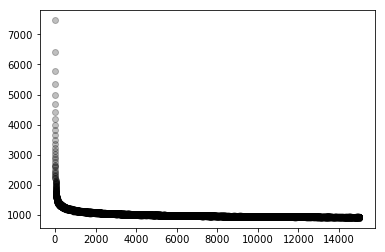

In [47]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [48]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

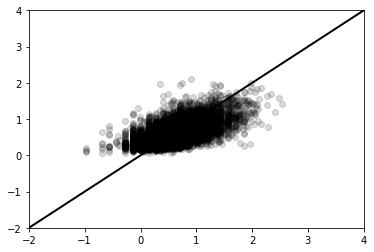

In [49]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [50]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 280.0624
[torch.FloatTensor of size 1]

In [51]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4109
[torch.FloatTensor of size 1]

In [52]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

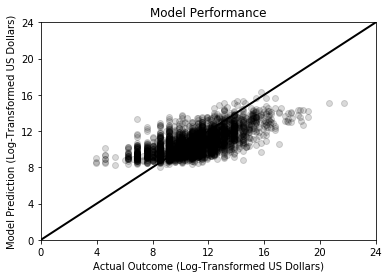

In [53]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 20%

In [54]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [55]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [56]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

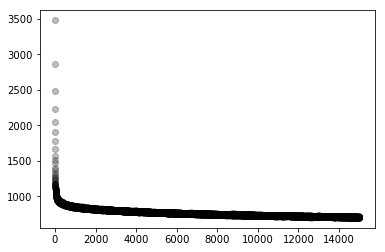

In [57]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [58]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

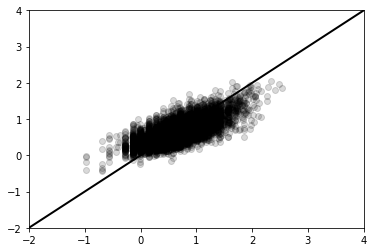

In [59]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [60]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 259.7663
[torch.FloatTensor of size 1]

In [61]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4536
[torch.FloatTensor of size 1]

In [62]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

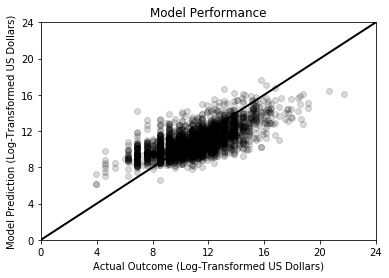

In [63]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 10%

In [64]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [65]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.1),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.1),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [66]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

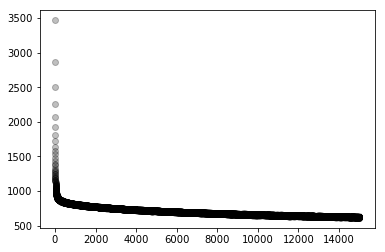

In [67]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [68]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

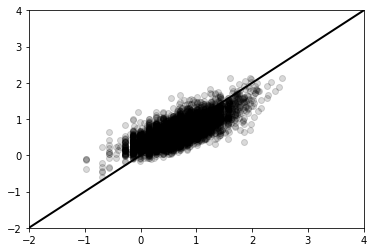

In [69]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [70]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 259.4849
[torch.FloatTensor of size 1]

In [71]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4542
[torch.FloatTensor of size 1]

In [72]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

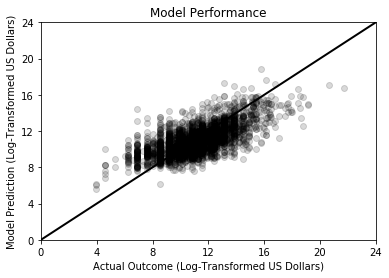

In [73]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

## Same Model, Dropout = 30%

In [74]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [75]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(34, 100),     # Hidden Layer (HL) 1
                            torch.nn.Dropout(p = 0.3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 100),    # HL 2
                            torch.nn.Dropout(p = 0.3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(100, 1))      # Outcome

In [76]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-3


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Switch the model to training mode
    model.train();
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

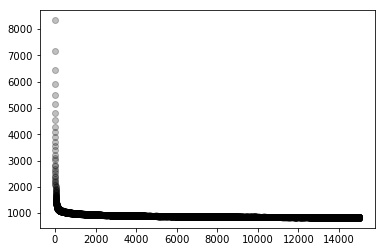

In [77]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [78]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

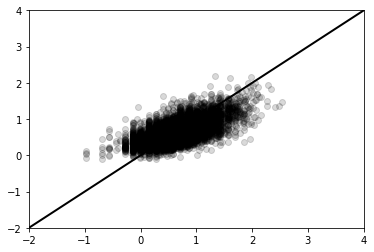

In [79]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Validation Set Performance

In [80]:
# Put the model in evaluation mode
model.eval()


# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 267.3170
[torch.FloatTensor of size 1]

In [81]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.4377
[torch.FloatTensor of size 1]

In [82]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

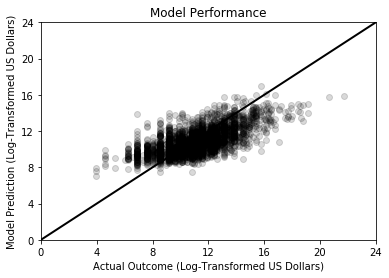

In [83]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")